In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

In [2]:
df_model = pd.read_pickle(r'C:\Course\Repo\Fraud detection\Files\df_model_data_after_FeatureEngineering_23.3.25.pkl')

#### <font color='Indigo'>Train Test Split

In [4]:
# Define the target and feature set
X = df_model.drop(columns=['is_fraud'])
X = X.astype({col: 'float64' for col in X.select_dtypes(include=['Int64']).columns})
y = df_model['is_fraud']

# Total number of samples
total_samples = len(df_model)

# First split: training and temporary (test + dev)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Second split: testing and development (dev)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Calculate percentages
train_percent = (X_train.shape[0] / total_samples) * 100
dev_percent = (X_dev.shape[0] / total_samples) * 100
test_percent = (X_test.shape[0] / total_samples) * 100

# Output the sizes of each set in percentages
print(f"Training set size: {train_percent:.2f}%")
print(f"Validation (Dev) set size: {dev_percent:.2f}%")
print(f"Testing set size: {test_percent:.2f}%")

Training set size: 70.00%
Validation (Dev) set size: 15.00%
Testing set size: 15.00%


## 🟦⚖️🟥Imbalanced Dataset

In [9]:
# Get counts
fraud_counts = df_model['is_fraud'].value_counts()

# Get ratios (proportions)
fraud_ratios = df_model['is_fraud'].value_counts(normalize=True).round(4) * 100  # multiply by 100 for percentage

# Combine counts and ratios into a DataFrame
fraud_summary = pd.DataFrame({
    'count': fraud_counts,
    'percentage': fraud_ratios
})
print(fraud_summary)

           count  percentage
is_fraud                    
0         298333       99.44
1           1667        0.56


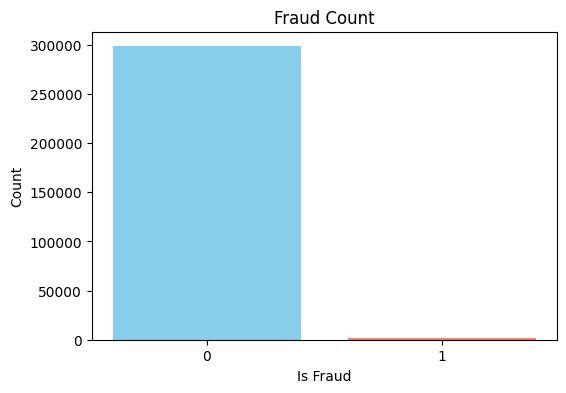

In [11]:
# Calculate the counts for is_fraud
fraud_counts = df_model['is_fraud'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(fraud_counts.index.astype(str), fraud_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.title('Fraud Count')
plt.show()

In [13]:
# Define the resampling techniques
resampling_techniques = {
    'ROS': RandomOverSampler(random_state=42),
    'RUS': RandomUnderSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    # 'TomekLinks': TomekLinks()  # Uncomment to include this technique
}

# Initialize a dictionary to store the results
results = {}

# Define the model with random_state for reproducibility
model = DecisionTreeClassifier(random_state=42)

# **Baseline Test: No resampling**
print("Applying Baseline (no resampling)...")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
f1_score_val = f1_score(y_test, y_pred)
results['Baseline'] = {'classification_report': report, 'f1_score': f1_score_val}
print(f"Performance of Baseline on the test set:\n{report}")
print(f"F1-score: {f1_score_val}\n")
print(confusion_matrix(y_test, y_pred))
print("-" * 80)

# Iterate through each resampling technique
for name, resampler in resampling_techniques.items():
    print(f"Applying {name}...")
    # Resample the training data
    X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
    print(f"Shape of resampled training data (after {name}): {Counter(y_resampled)}")
    
    # Train the model on the resampled training data
    model.fit(X_resampled, y_resampled)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the performance
    report = classification_report(y_test, y_pred)
    f1_score_val = f1_score(y_test, y_pred)
    
    results[name] = {'classification_report': report, 'f1_score': f1_score_val}
    print(f"Performance of {name} on the test set:\n{report}")
    print(f"F1-score: {f1_score_val}\n")
    print(confusion_matrix(y_test, y_pred))
    print("-" * 80)

# Find the best technique based on F1-score (including Baseline)
best_technique = max(results, key=lambda k: results[k]['f1_score'])
print(f"The best technique based on F1-score is: {best_technique}")
print(f"Performance of the best technique ({best_technique}):\n{results[best_technique]['classification_report']}")

Applying Baseline (no resampling)...
Performance of Baseline on the test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44739
           1       0.91      0.85      0.88       261

    accuracy                           1.00     45000
   macro avg       0.95      0.92      0.94     45000
weighted avg       1.00      1.00      1.00     45000

F1-score: 0.8752475247524752

[[44716    23]
 [   40   221]]
--------------------------------------------------------------------------------
Applying ROS...
Shape of resampled training data (after ROS): Counter({0: 208827, 1: 208827})
Performance of ROS on the test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44739
           1       0.92      0.82      0.86       261

    accuracy                           1.00     45000
   macro avg       0.96      0.91      0.93     45000
weighted avg       1.00      1.00      1.00     450

### <br>
##  <font color='yellow'>⚖️Resampling Strategy Comparison Report

### Overview
In an effort to improve my credit card fraud detection model—given the severe class imbalance (only 0.56% fraud)—I evaluated several resampling techniques. These included:
- **Baseline (No Resampling)**
- **Random Over Sampling (ROS)**
- **Random Under Sampling (RUS)**
- **SMOTE**
- **ADASYN**
- **BorderlineSMOTE**
- **SMOTETomek**

### Experimental Results Summary

- **Baseline (No Resampling)**:
  - **F1-score:** 0.875
  - **Confusion Matrix:**  
    ```
    [[44716    23]
     [   40   221]]
    ```
  - **Observations:** The classifier already performed robustly on the imbalanced data with high precision and recall for the minority class.

- **Random Over Sampling (ROS)**:
  - **F1-score:** 0.864
  - **Confusion Matrix:**  
    ```
    [[44720    19]
     [   48   213]]
    ```
  - **Observations:** While ROS balanced the training data, the performance slightly dropped compared to the baseline, suggesting that the model’s current capacity is sufficient to handle the imbalance.

- **Other Resampling Techniques**:
  - **RUS, SMOTE, ADASYN, BorderlineSMOTE, and SMOTETomek** all resulted in lower F1-scores (ranging from 0.19 to 0.738).
  - **Observations:** These methods either significantly reduced performance (e.g., RUS with an F1-score of 0.19) or did not improve upon the baseline, likely due to overfitting or loss of important signal in the minority class.

### Rationale for Choosing Baseline and ROS

- **Baseline as the Best Performer:**  
  The Baseline model, without any resampling, achieved the highest F1-score of 0.875. This indicates that the decision tree classifier is capable of effectively handling the imbalance in the data, and any additional resampling might be unnecessary or even detrimental.

- **ROS for Comparison:**  
  Although ROS slightly reduced the F1-score (0.864), its performance is still comparable to the Baseline. ROS is simple to implement and maintains the original data characteristics, making it a good candidate for further comparative studies in more complex modeling scenarios.

### Conclusion

Based on our experimental results:
- The **Baseline** approach is the most effective for this particular dataset.
- **ROS** is selected as the next best method for comparison, due to its simplicity and relatively similar performance.
- More complex resampling techniques did not yield improvements and, in some cases, degraded the model performance.

These insights will help in focusing further model development and tuning on approaches that either retain the original data distribution or make minimal modifications (such as ROS), rather than more aggressive resampling strategies.



In [8]:
print(1)

1


In [10]:
print(1)

1


In [17]:
print(1)

1


# Model Selection

In [15]:
def perform_model_selection(X_train, X_test, y_train, y_test, dataset_name=""):
    """
    Performs classifier model selection on the given dataset.

    Args:
        X_train (pd.DataFrame or np.ndarray): Training features.
        X_test (pd.DataFrame or np.ndarray): Testing features.
        y_train (pd.Series or np.ndarray): Training target.
        y_test (pd.Series or np.ndarray): Testing target.
        dataset_name (str, optional): Name of the dataset for output labeling. Defaults to "".
    """
    print(f"\n{'='*50}")
    print(f"Performing Model Selection on: {dataset_name}")
    print(f"{'='*50}")

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define classifiers
    classifiers = {
        'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
        #'Support Vector Machine': SVC(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'Naive Bayes': GaussianNB()
    }

    # Evaluation metric: F1 Score
    scoring_metric = make_scorer(f1_score)

    # Cross-validation setup
    n_folds = 5
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    # Cross-validation results
    cv_results = {}

    print("Performing cross-validation...")
    for name, clf in classifiers.items():
        print(f"Evaluating {name}...")
        scores = cross_val_score(clf, X_train_scaled, y_train, cv=cv, scoring=scoring_metric, n_jobs=-1, error_score='raise')
        cv_results[name] = scores.mean()

    print("\nCross-Validation Results (Mean F1-Score):")
    for name, score in sorted(cv_results.items(), key=lambda item: item[1], reverse=True):
        print(f"{name}: {score:.4f}")

    # Select best model based on cross-validation performance
    best_model_name = max(cv_results, key=cv_results.get)
    best_model = classifiers[best_model_name]
    print(f"\nBest model based on cross-validation: {best_model_name}")

    # Train best model using the scaled training data
    best_model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = best_model.predict(X_test_scaled)

    # Evaluate best model on the test set
    print("\nEvaluation of the Best Model on the Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # If the classifier supports probability estimates, calculate ROC AUC Score
    if hasattr(best_model, "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"\nROC AUC Score: {roc_auc:.4f}")
    else:
        print("\nROC AUC Score not available for this classifier.")


#### <font color='Indigo'> Perform model selection on the original imbalanced dataset

In [17]:
perform_model_selection(X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy(), dataset_name="Original Imbalanced Dataset")


Performing Model Selection on: Original Imbalanced Dataset
Performing cross-validation...
Evaluating Logistic Regression...
Evaluating Support Vector Machine...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Naive Bayes...

Cross-Validation Results (Mean F1-Score):
Random Forest: 0.9184
Gradient Boosting: 0.9047
Decision Tree: 0.8790
Support Vector Machine: 0.6653
Naive Bayes: 0.3704
Logistic Regression: 0.2313

Best model based on cross-validation: Random Forest

Evaluation of the Best Model on the Test Set:
[[44739     0]
 [   49   212]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44739
           1       1.00      0.81      0.90       261

    accuracy                           1.00     45000
   macro avg       1.00      0.91      0.95     45000
weighted avg       1.00      1.00      1.00     45000


ROC AUC Score: 0.9934


#### <font color='Indigo'> Perform model selection on the balanced dataset

In [20]:
# Handle class imbalance using Random Over-Sampling
print("\nApplying Random Over-Sampling for handling class imbalance...")
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(f"Original class distribution: {y.value_counts()}")
print(f"Class distribution after Random Over-Sampling: {y_resampled.value_counts()}")

# First split: training and temporary (test + dev)
X_train_resampled, X_temp_resampled, y_train_resampled, y_temp_resampled = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
# Second split: testing and development (dev)
X_dev_resampled, X_test_resampled, y_dev_resampled, y_test_resampled = train_test_split(X_temp_resampled, y_temp_resampled, test_size=0.5, random_state=42)
# Perform model selection on the balanced dataset
perform_model_selection(X_train_resampled.copy(), X_test_resampled.copy(), y_train_resampled.copy(), y_test_resampled.copy(), dataset_name="Dataset with Random Over-Sampling")


Applying Random Over-Sampling for handling class imbalance...
Original class distribution: is_fraud
0    298333
1      1667
Name: count, dtype: int64
Class distribution after Random Over-Sampling: is_fraud
0    298333
1    298333
Name: count, dtype: int64

Performing Model Selection on: Dataset with Random Over-Sampling
Performing cross-validation...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Naive Bayes...

Cross-Validation Results (Mean F1-Score):
Random Forest: 1.0000
Decision Tree: 0.9995
Gradient Boosting: 0.9857
Logistic Regression: 0.9209
Naive Bayes: 0.8667

Best model based on cross-validation: Random Forest

Evaluation of the Best Model on the Test Set:
[[44506     1]
 [    0 44993]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44507
           1       1.00      1.00      1.00     44993

    accuracy      

In [ ]:

# --- Optional: Feature Scaling (can be helpful for GradientBoosting) ---
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)
#X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
# --- End of Optional Scaling ---

# Define the parameter grids for fine-tuning

# RandomForestClassifier parameters to tune
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'criterion': ['gini', 'entropy']
}

# GradientBoostingClassifier parameters to tune
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0]
}

# Define the scoring metric for evaluation (consider F1-score for the minority class - fraud)
scoring_metric = 'f1'  # Or 'f1_weighted' or a custom scorer

# For imbalanced datasets like credit card fraud, StratifiedKFold is crucial
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Fine-tuning RandomForestClassifier ---
print("--- Fine-tuning RandomForestClassifier ---")
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=rf_param_grid,
                               scoring=scoring_metric,
                               cv=cv,
                               n_jobs=-1,  # Use all available cores
                               verbose=2)

rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("Best parameters for RandomForestClassifier:", rf_grid_search.best_params_)
print("Best cross-validation score for RandomForestClassifier:", rf_grid_search.best_score_)

# Evaluate the best RandomForestClassifier model on the test set
best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_resampled)
print("\nClassification Report for Best RandomForestClassifier (Test Set):")
print(classification_report(y_test_resampled, y_pred_rf))
print("\nConfusion Matrix for Best RandomForestClassifier (Test Set):")
print(confusion_matrix(y_test_resampled, y_pred_rf))

# Calculate AUC on the test set
y_pred_proba_rf = best_rf_model.predict_proba(X_test_resampled)[:, 1]
roc_auc_rf = roc_auc_score(y_test_resampled, y_pred_proba_rf)
print(f"\nAUC for Best RandomForestClassifier (Test Set): {roc_auc_rf:.4f}")

# --- Fine-tuning GradientBoostingClassifier ---
print("\n--- Fine-tuning GradientBoostingClassifier ---")
gb_grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                               param_grid=gb_param_grid,
                               scoring=scoring_metric,
                               cv=cv,
                               n_jobs=-1,  # Use all available cores
                               verbose=2)

gb_grid_search.fit(X_train_resampled, y_train_resampled)

# Print the best parameters and best score
print("Best parameters for GradientBoostingClassifier:", gb_grid_search.best_params_)
print("Best cross-validation score for GradientBoostingClassifier:", gb_grid_search.best_score_)

# Evaluate the best GradientBoostingClassifier model on the test set
best_gb_model = gb_grid_search.best_estimator_
y_pred_gb = best_gb_model.predict(X_test_resampled)
print("\nClassification Report for Best GradientBoostingClassifier (Test Set):")
print(classification_report(y_test_resampled, y_pred_gb))
print("\nConfusion Matrix for Best GradientBoostingClassifier (Test Set):")
print(confusion_matrix(y_test_resampled, y_pred_gb))

# Calculate AUC on the test set
y_pred_proba_gb = best_gb_model.predict_proba(X_test_resampled)[:, 1]
roc_auc_gb = roc_auc_score(y_test_resampled, y_pred_proba_gb)
print(f"\nAUC for Best GradientBoostingClassifier (Test Set): {roc_auc_gb:.4f}")

--- Fine-tuning RandomForestClassifier ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
